In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import random

print("PyTorch version:", torch.__version__)


PyTorch version: 2.8.0+cu126


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

DATA_DIR = Path("/content/drive/MyDrive/Guvi/Project_CNN/Covid19-dataset")
BATCH_SIZE = 16
EPOCHS = 15
LR = 0.0001
IMG_SIZE = 224
MODEL_PATH = "best_model.pth"
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Device: cuda


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
train_dataset = datasets.ImageFolder(DATA_DIR / "train", train_transform)
test_dataset = datasets.ImageFolder(DATA_DIR / "test", test_transform)

# Split train into train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_dataset)}")
print(f"Classes: {class_names}")

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=4)


Train: 200, Val: 51, Test: 66
Classes: ['Covid', 'Normal', 'Viral Pneumonia']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


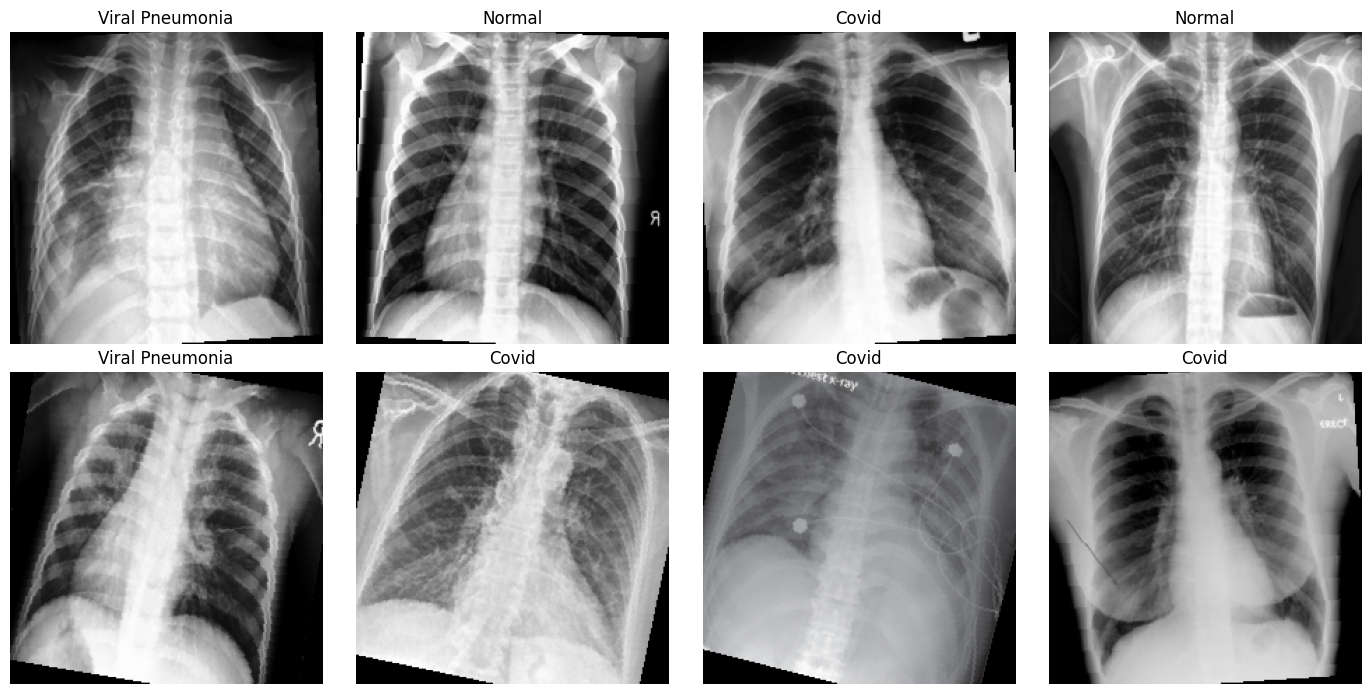

In [7]:
def show_images(images, labels, preds=None):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = images[i].numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        if preds is not None:
            color = 'green' if preds[i] == labels[i] else 'red'
            ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}', color=color)
        else:
            ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_images(images, labels)

In [8]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Training {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 138MB/s]


Model has 6,956,931 parameters
Training 6,956,931 parameters


In [9]:
best_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss / train_total
    train_acc = train_correct / train_total

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✓ Epoch {epoch+1}/{EPOCHS} | Train: {train_acc:.3f} | Val: {val_acc:.3f} | SAVED")
    else:
        print(f"  Epoch {epoch+1}/{EPOCHS} | Train: {train_acc:.3f} | Val: {val_acc:.3f}")

    scheduler.step()

print(f"\nBest validation accuracy: {best_acc:.4f}")

✓ Epoch 1/15 | Train: 0.710 | Val: 0.843 | SAVED
✓ Epoch 2/15 | Train: 0.920 | Val: 0.941 | SAVED
  Epoch 3/15 | Train: 0.965 | Val: 0.941
✓ Epoch 4/15 | Train: 0.965 | Val: 0.961 | SAVED
  Epoch 5/15 | Train: 0.945 | Val: 0.922
✓ Epoch 6/15 | Train: 0.990 | Val: 0.980 | SAVED
  Epoch 7/15 | Train: 0.980 | Val: 0.980
✓ Epoch 8/15 | Train: 0.990 | Val: 1.000 | SAVED
  Epoch 9/15 | Train: 0.990 | Val: 0.961
  Epoch 10/15 | Train: 0.995 | Val: 0.980
  Epoch 11/15 | Train: 0.990 | Val: 0.980
  Epoch 12/15 | Train: 0.995 | Val: 0.980
  Epoch 13/15 | Train: 1.000 | Val: 0.980
  Epoch 14/15 | Train: 0.990 | Val: 0.980
  Epoch 15/15 | Train: 0.995 | Val: 0.980

Best validation accuracy: 1.0000


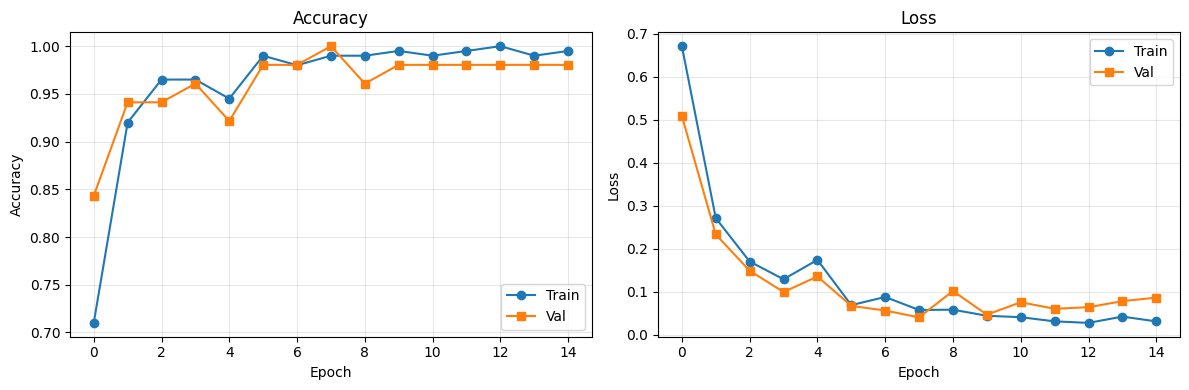

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_acc'], label='Train', marker='o')
ax1.plot(history['val_acc'], label='Val', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('Accuracy')
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_loss'], label='Train', marker='o')
ax2.plot(history['val_loss'], label='Val', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Loss')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import pandas as pd

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("="*60)
print("TEST EVALUATION RESULTS")
print("="*60)
print(f"\nOverall Metrics:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {precision_avg:.4f} (weighted)")
print(f"  Recall:    {recall_avg:.4f} (weighted)")
print(f"  F1-Score:  {f1_avg:.4f} (weighted)")

print(f"\nPer-Class Metrics:")
print("-"*60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:20} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")

print("\n" + classification_report(all_labels, all_preds, target_names=class_names))

TEST EVALUATION RESULTS

Overall Metrics:
  Accuracy:  0.9394
  Precision: 0.9495 (weighted)
  Recall:    0.9394 (weighted)
  F1-Score:  0.9388 (weighted)

Per-Class Metrics:
------------------------------------------------------------
Covid                | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Normal               | Precision: 1.0000 | Recall: 0.8000 | F1: 0.8889
Viral Pneumonia      | Precision: 0.8333 | Recall: 1.0000 | F1: 0.9091

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.80      0.89        20
Viral Pneumonia       0.83      1.00      0.91        20

       accuracy                           0.94        66
      macro avg       0.94      0.93      0.93        66
   weighted avg       0.95      0.94      0.94        66



✓ Saved: confusion_matrix.png


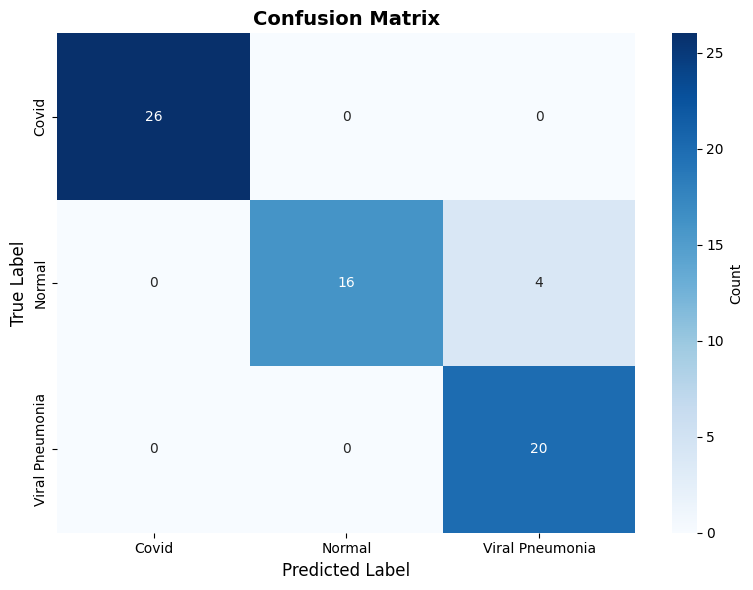

In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

In [13]:
metrics_data = {
    'Class': class_names + ['Overall (Weighted Avg)'],
    'Precision': list(precision) + [precision_avg],
    'Recall': list(recall) + [recall_avg],
    'F1-Score': list(f1) + [f1_avg],
    'Accuracy': ['-'] * len(class_names) + [f'{test_acc:.4f}']
}

df_metrics = pd.DataFrame(metrics_data)
print("\n" + "="*60)
print("METRICS SUMMARY TABLE")
print("="*60)
print(df_metrics.to_string(index=False))

# Save to CSV
df_metrics.to_csv('metrics_summary.csv', index=False)
print("\n✓ Saved: metrics_summary.csv")


METRICS SUMMARY TABLE
                 Class  Precision   Recall  F1-Score Accuracy
                 Covid   1.000000 1.000000  1.000000        -
                Normal   1.000000 0.800000  0.888889        -
       Viral Pneumonia   0.833333 1.000000  0.909091        -
Overall (Weighted Avg)   0.949495 0.939394  0.938782   0.9394

✓ Saved: metrics_summary.csv



✓ Saved: roc_curves.png


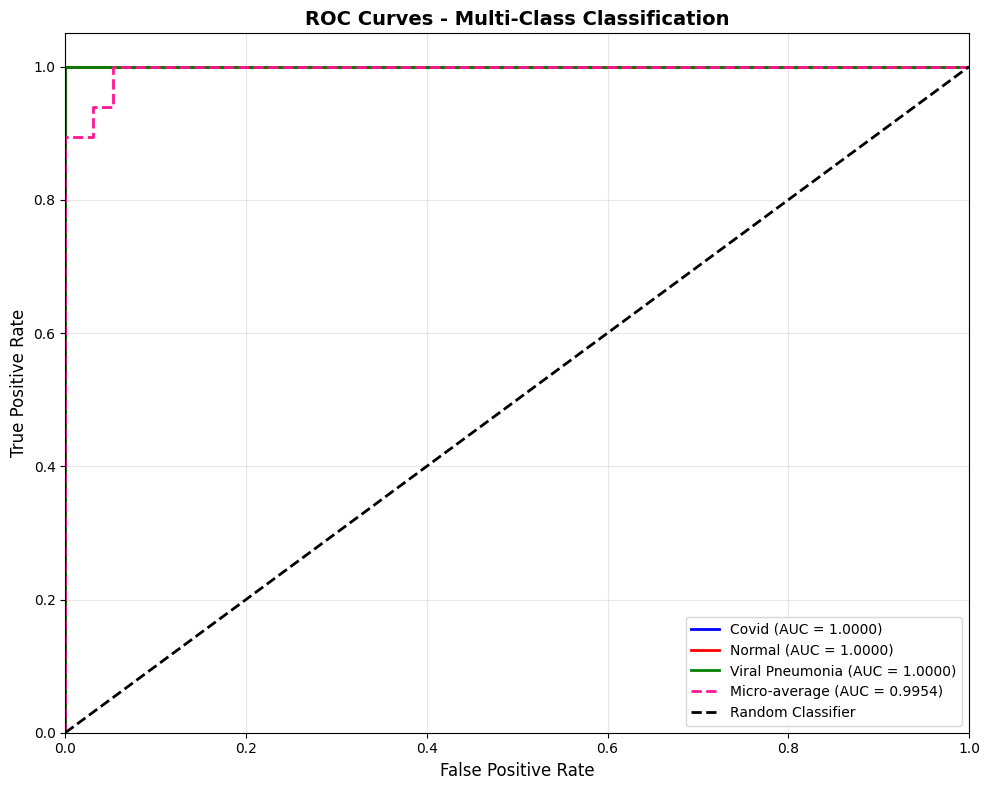


ROC-AUC Scores:
----------------------------------------
  Covid               : 1.0000
  Normal              : 1.0000
  Viral Pneumonia     : 1.0000
  Micro-average       : 0.9954
  Macro-average       : 1.0000


In [14]:
# Cell 12: ROC Curve and AUC
from itertools import cycle

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(all_labels, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], all_probs[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = roc_auc_score(y_test_bin, all_probs, average='micro', multi_class='ovr')

# Compute macro-average AUC
roc_auc["macro"] = roc_auc_score(y_test_bin, all_probs, average='macro', multi_class='ovr')

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: roc_curves.png")
plt.show()

print(f"\nROC-AUC Scores:")
print("-"*40)
for i, class_name in enumerate(class_names):
    print(f"  {class_name:20}: {roc_auc[i]:.4f}")
print(f"  {'Micro-average':20}: {roc_auc['micro']:.4f}")
print(f"  {'Macro-average':20}: {roc_auc['macro']:.4f}")

/tmp/ipython-input-3632007713.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')


✓ Saved: metrics_visualization.png


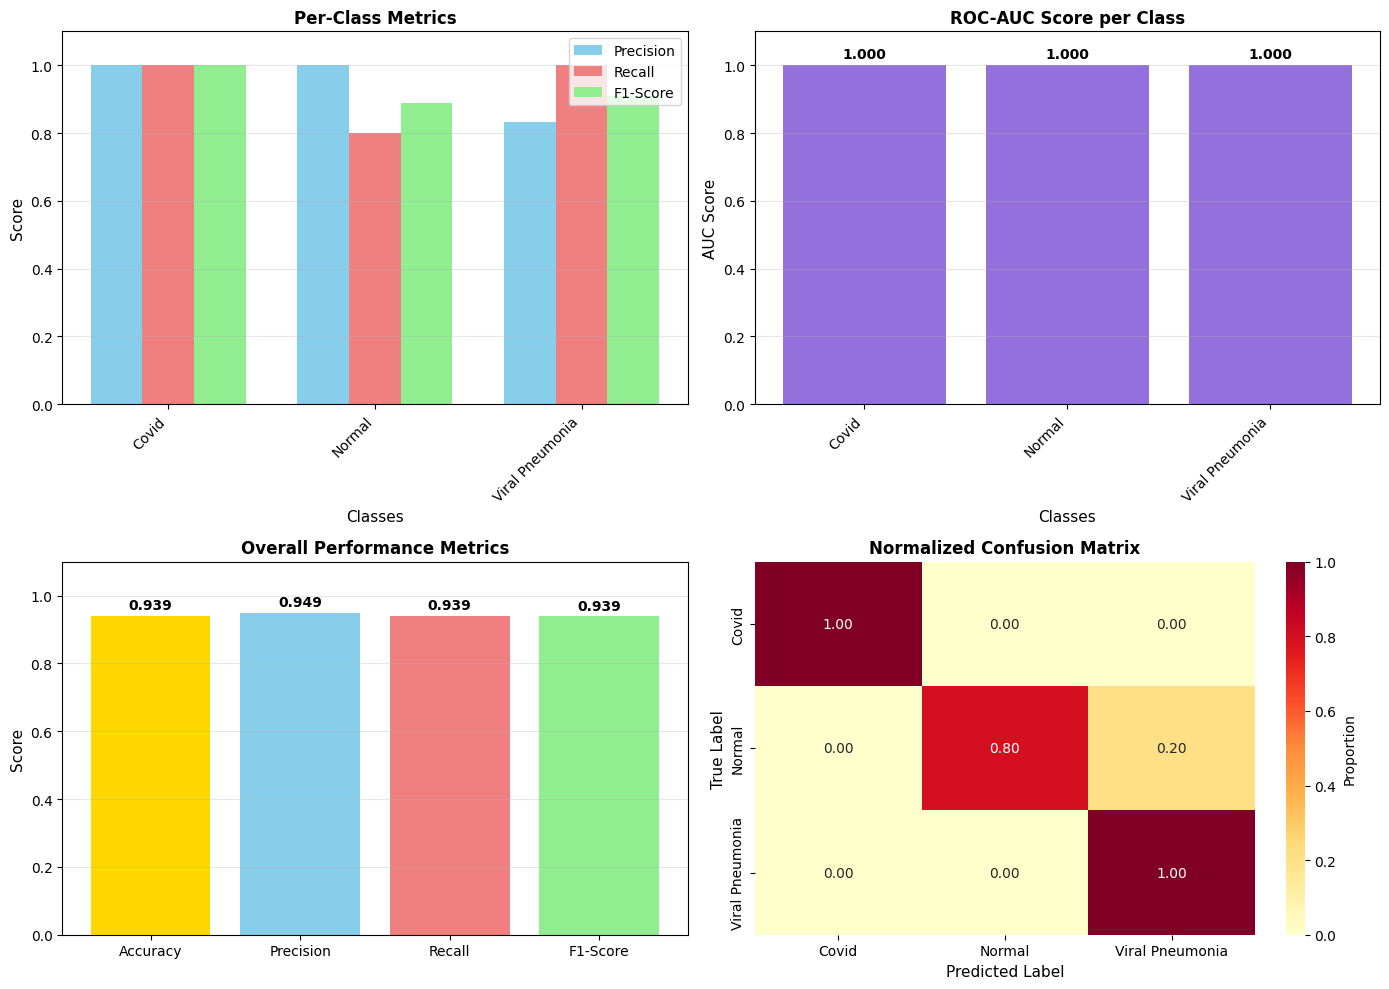

In [15]:
# Cell 13: Bar Plot of Metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

x = np.arange(len(class_names))
width = 0.25

# Precision, Recall, F1 per class
axes[0, 0].bar(x - width, precision, width, label='Precision', color='skyblue')
axes[0, 0].bar(x, recall, width, label='Recall', color='lightcoral')
axes[0, 0].bar(x + width, f1, width, label='F1-Score', color='lightgreen')
axes[0, 0].set_xlabel('Classes', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)

# AUC per class
axes[0, 1].bar(class_names, [roc_auc[i] for i in range(num_classes)], color='mediumpurple')
axes[0, 1].set_xlabel('Classes', fontsize=11)
axes[0, 1].set_ylabel('AUC Score', fontsize=11)
axes[0, 1].set_title('ROC-AUC Score per Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate([roc_auc[i] for i in range(num_classes)]):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Overall metrics comparison
overall_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
overall_values = [test_acc, precision_avg, recall_avg, f1_avg]
axes[1, 0].bar(overall_metrics, overall_values, color=['gold', 'skyblue', 'lightcoral', 'lightgreen'])
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Overall Performance Metrics', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(overall_values):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Confusion matrix heatmap (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1, 1],
            cbar_kws={'label': 'Proportion'})
axes[1, 1].set_xlabel('Predicted Label', fontsize=11)
axes[1, 1].set_ylabel('True Label', fontsize=11)
axes[1, 1].set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: metrics_visualization.png")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


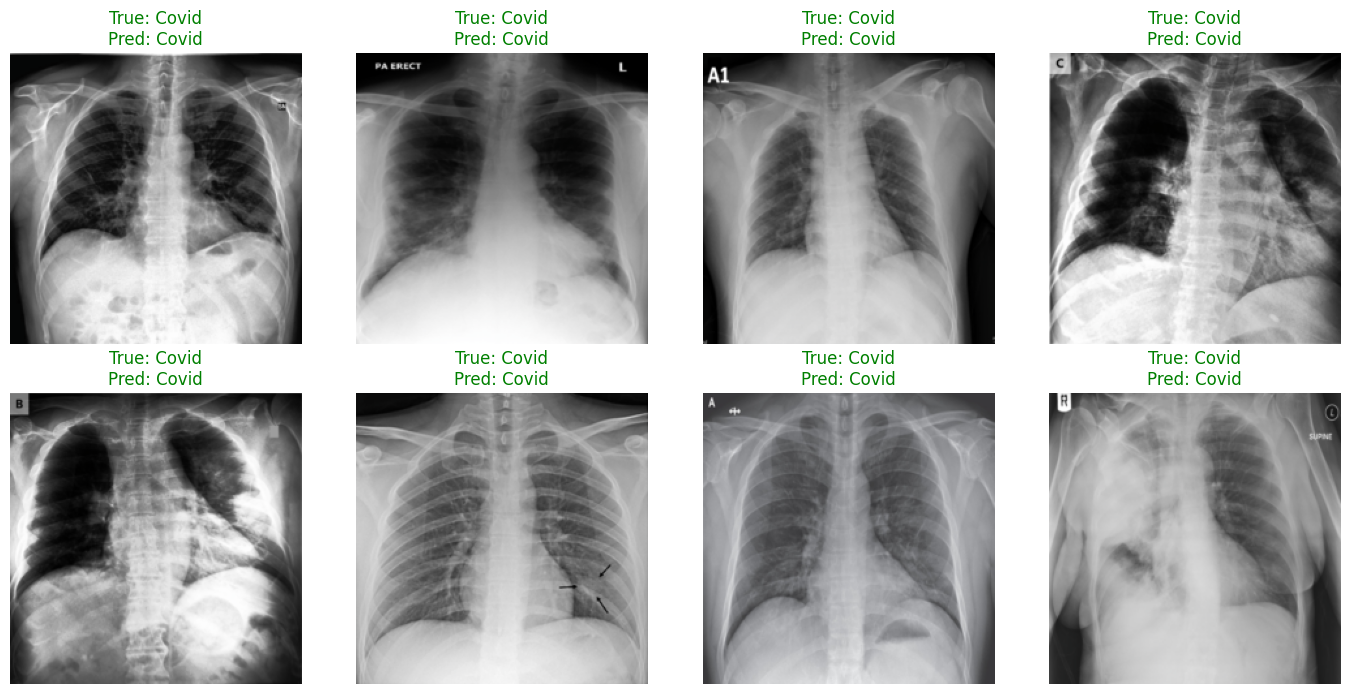

In [16]:
# Cell 11: Visualize predictions
model.eval()
imgs, labels = next(iter(test_loader))
imgs_gpu = imgs.to(DEVICE)

with torch.no_grad():
    outputs = model(imgs_gpu)
    preds = outputs.argmax(1).cpu()

show_images(imgs, labels, preds)


✓ Saved: training_history.png


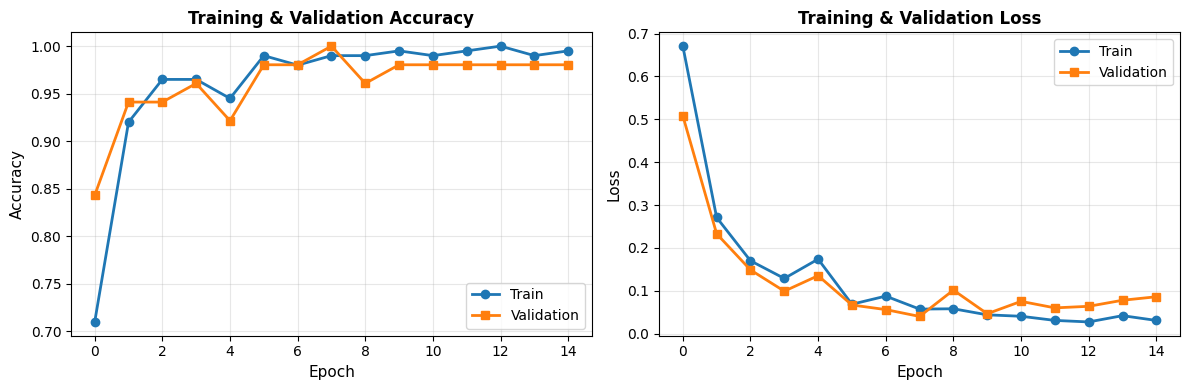

In [17]:
# Cell 12: Save training history plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_acc'], label='Train', marker='o', linewidth=2)
ax1.plot(history['val_acc'], label='Validation', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.legend(fontsize=10)
ax1.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_loss'], label='Train', marker='o', linewidth=2)
ax2.plot(history['val_loss'], label='Validation', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Loss', fontsize=11)
ax2.legend(fontsize=10)
ax2.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_history.png")
plt.show()

In [18]:
# Cell 12: Simple Grad-CAM Implementation
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        # Hook the last conv layer (features in DenseNet)
        target_layer = model.features[-1]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, target_class].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))

        cam = torch.zeros(activations.shape[1:], device=DEVICE)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, target_class

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✓ Saved: gradcam_examples.png


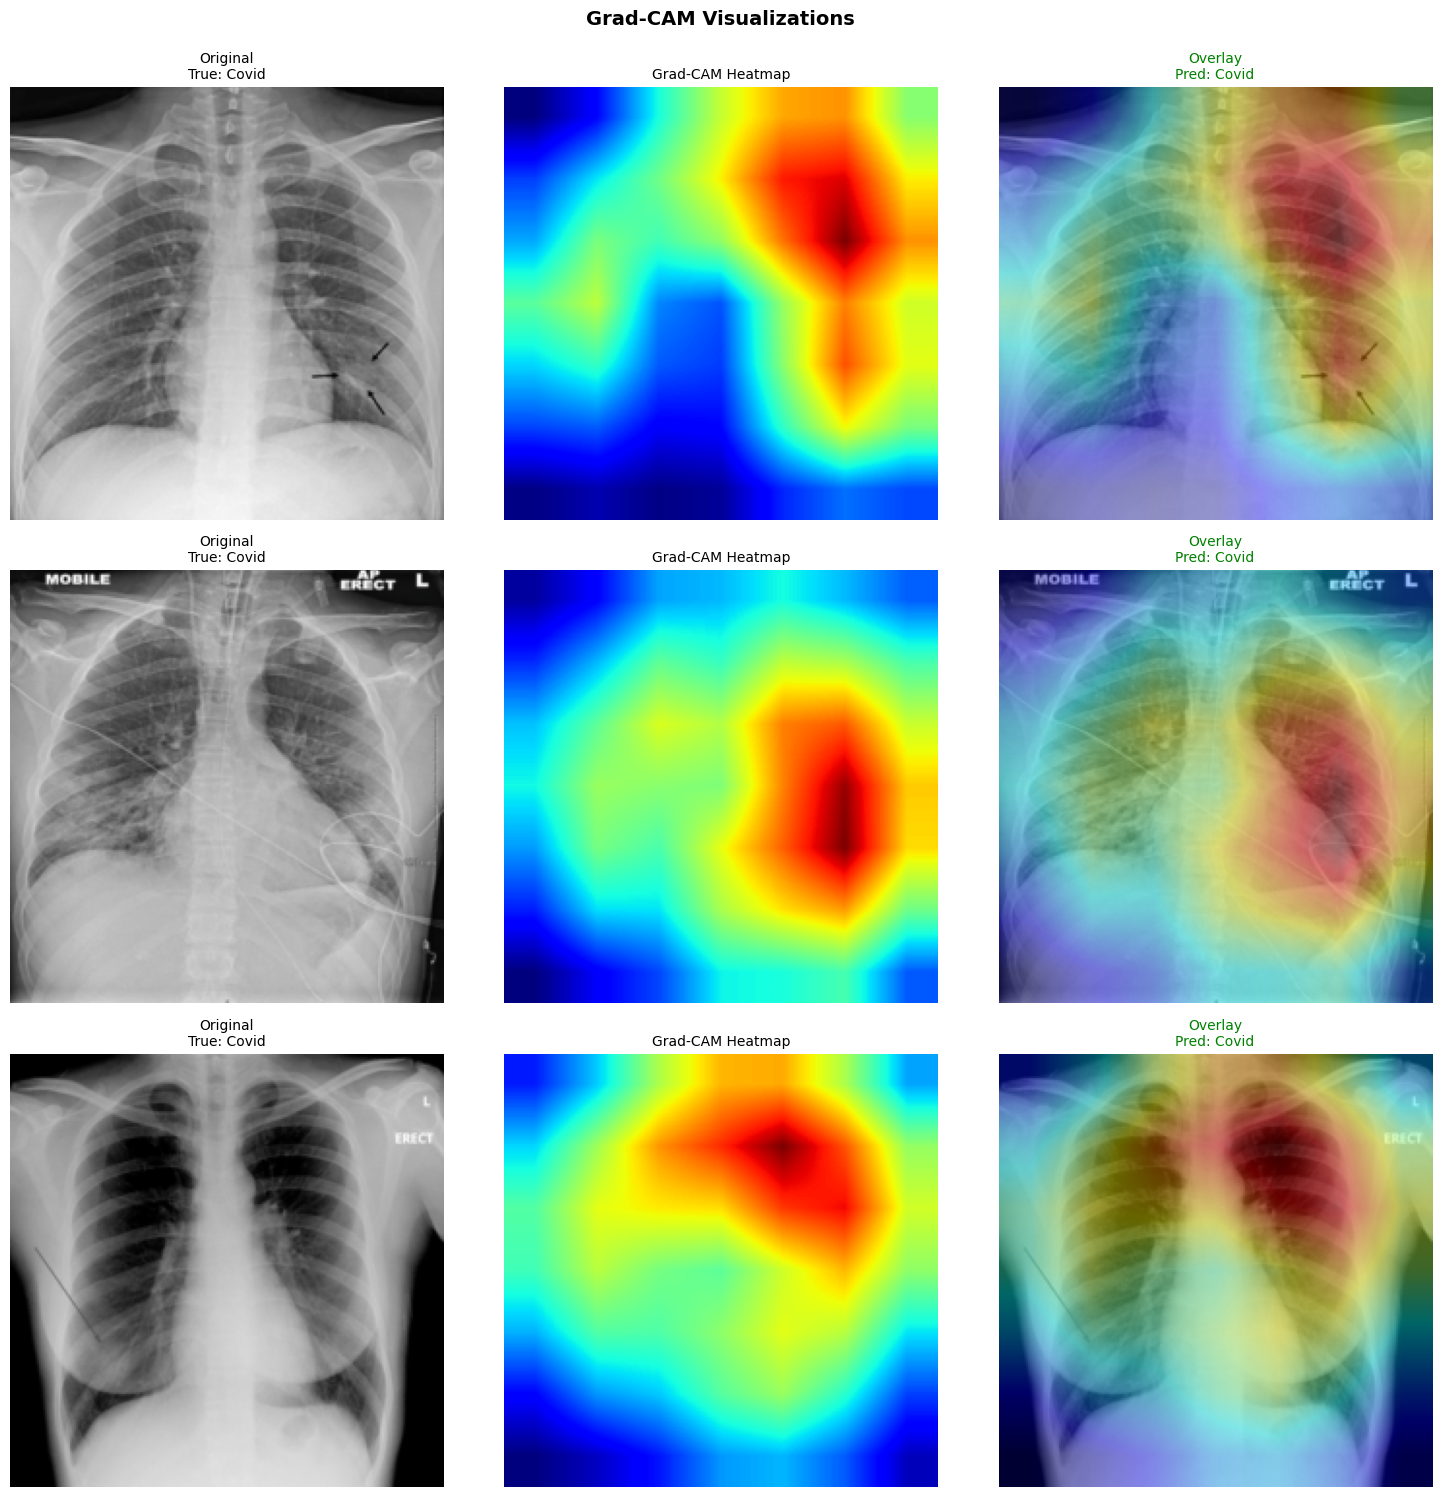

In [19]:
# Cell 13: Test Grad-CAM on multiple samples
gradcam = GradCAM(model)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sample_indices = [5, 15, 25]  # Test different samples

for row, idx in enumerate(sample_indices):
    # Get a test image
    img_tensor, label = test_dataset[idx]
    img_tensor_batch = img_tensor.unsqueeze(0).to(DEVICE)

    # Generate CAM
    cam, pred_class = gradcam.generate_cam(img_tensor_batch)

    # Denormalize image for display
    img_display = img_tensor.numpy().transpose(1, 2, 0)
    img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_display = np.clip(img_display, 0, 1)

    # Create heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = heatmap * 0.4 + img_display * 0.6

    # Display
    axes[row, 0].imshow(img_display)
    axes[row, 0].set_title(f'Original\nTrue: {class_names[label]}', fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(cam, cmap='jet')
    axes[row, 1].set_title('Grad-CAM Heatmap', fontsize=10)
    axes[row, 1].axis('off')

    color = 'green' if pred_class == label else 'red'
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f'Overlay\nPred: {class_names[pred_class]}', fontsize=10, color=color)
    axes[row, 2].axis('off')

plt.suptitle('Grad-CAM Visualizations', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('gradcam_examples.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gradcam_examples.png")
plt.show()

In [20]:

# Cell 14: Save model with class names for inference
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes
}, 'model_for_inference.pth')

print("✓ Model saved with class names for inference!")
print(f"Classes saved: {class_names}")

✓ Model saved with class names for inference!
Classes saved: ['Covid', 'Normal', 'Viral Pneumonia']
